# Init

In [4]:
%matplotlib inline

import csv
import itertools
import math
import matplotlib
import time
import logging
import sys
import os
import random
import warnings

import gensim

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from sklearn import random_projection
from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, spdiags
from scipy.io import loadmat, savemat
from scipy.spatial.distance import cosine
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, MultiLabelBinarizer

In [5]:
from sklearn import preprocessing

In [6]:
from scoring import scoring

In [7]:
# to ignore sklearn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [8]:
%load_ext autoreload
%autoreload 2

# Load Data

## Blogcatalog

In [9]:
blogcatalog = loadmat('example_graphs/blogcatalog.mat')
blog_labels = blogcatalog['group']
blog_A = blogcatalog['network']
N = blog_A.shape[0]

In [10]:
blog_A

<10312x10312 sparse matrix of type '<class 'numpy.float64'>'
	with 667966 stored elements in Compressed Sparse Column format>

In [11]:
N

10312

In [12]:
d = [l[0] for l in blog_A.sum(axis=1).tolist()]

alpha=  1.258526391056572   sigma=  0.0025458536330247006


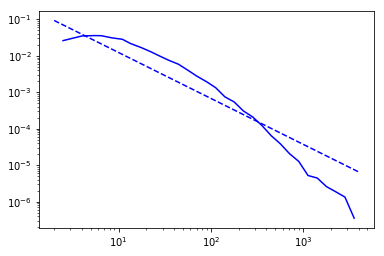

In [13]:
import powerlaw

fit = powerlaw.Fit(np.array(d)+1,xmin=1,discrete=True)
fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf(color= 'b')

print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

# Random Projection

In [49]:
# projection method: choose from Gaussian and Sparse
# input matrix: choose from adjacency and transition matrix
# alpha adjusts the weighting of nodes according to their degree
def randne_projection(A, q=3, dim=128, projection_method='gaussian', input_matrix='adj', alpha=None):
    assert input_matrix == 'adj' or input_matrix == 'trans'
    assert projection_method == 'gaussian' or projection_method == 'sparse'
    
    N = A.shape[0]
    if input_matrix == 'adj':
        M = A
    else:
        N = A.shape[0]
        normalizer = spdiags(np.squeeze(1.0 / csc_matrix.sum(A, axis=1) ), 0, N, N)
        M = normalizer @ A
    # Gaussian projection matrix
    if projection_method == 'gaussian':
        transformer = random_projection.GaussianRandomProjection(n_components=dim, random_state=42)
    # Sparse projection matrix
    else:
        transformer = random_projection.SparseRandomProjection(n_components=dim, random_state=42)
    Y = transformer.fit(M)
    # Random projection for A
    if alpha is not None:
        Y.components_ = Y.components_ @ spdiags( \
                        np.squeeze(np.power(csc_matrix.sum(A, axis=1), alpha)), 0, N, N)
    cur_U = transformer.transform(M)
    U_list = [cur_U]
    
    for i in range(2, q + 1):
        cur_U = M @ cur_U
        U_list.append(cur_U)
    return U_list

In [50]:
# When weights is None, concatenate instead of linearly combines the embeddings from different powers of A
def randne_merge(U_list, weights, normalization=False):
    dense_U_list = [_U.todense() for _U in U_list] if type(U_list[0]) == csc_matrix else U_list
    _U_list = [normalize(_U, norm='l2', axis=1) for _U in dense_U_list] if normalization else dense_U_list

    if weights is None:
        return np.concatenate(_U_list, axis=1)
    U = np.zeros_like(_U_list[0])
    for cur_U, weight in zip(_U_list, weights):
        U += cur_U * weight
    # U = preprocessing.scale(U.todense())
    U = U.todense()
    # U = normalize(U.todense(), norm='l2', axis=1)
    return U

In [51]:
# A is always the adjacency matrix
# the choice between adj matrix and trans matrix is decided in the conf
def randne_wrapper(A, conf):
    U_list = randne_projection(A,
                               q=len(conf['weights']),
                               dim=conf['dim'],
                               projection_method=conf['projection_method'],
                               input_matrix=conf['input_matrix'],
                               alpha=conf['alpha'],
    )
    U = randne_merge(U_list, conf['weights'], conf['normalization'])
    return U

# Link Prediction

In [32]:
import networkx as nx
from scipy.sparse import find
from random import sample
from scipy.spatial.distance import pdist, squareform

In [33]:
G = nx.from_scipy_sparse_matrix(blog_A)
tree = nx.minimum_spanning_tree(G)
G_nodes, G_edges, tree_edges = G.nodes(), G.edges(), tree.edges()
n_edges_70 = int(0.7*len(G_edges))

In [34]:
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0, 7.81, 45.28],
        'normalization': True,
        'dim': 512,
        'alpha': -0.628,
        'C': 0.1
}

In [69]:
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'adj',
        'weights': [1.0, 0.01],
        'normalization': False,
        'dim': 512,
        'alpha': 0.2,
        'C': 0.1
}

In [72]:
from numpy import inner as cosine

In [73]:
%%time
scores_negative = []
scores_random = []

for i in range(1):#(5):

    sampled_edges = sample(G_edges, n_edges_70-len(tree.edges()))
    tree.add_edges_from(sampled_edges)

    #Artificially removed:
    edges_to_test = [edge for edge in G.edges() if edge not in tree.edges()]

    #Edges that never existed
    negatives = []
    while len(negatives)<len(edges_to_test):
        rand_edge = sample(G_nodes, 2)
        if rand_edge not in G_edges:
            negatives.append(rand_edge)

    #Random sample from existing/non-existing edges
    rand_pairs = [sample(G_nodes, 2) for i in range(len(edges_to_test))]

    blog_A_70 = nx.to_scipy_sparse_matrix(tree)

    U = randne_wrapper(blog_A_70, conf)
    distances_negative = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in negatives])
    distances_random = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in rand_pairs])
    distances_pos = np.array([cosine(U[edge[0]], U[edge[1]]) for edge in edges_to_test])
    
    scores_negative.append((distances_pos<distances_negative).sum()/len(distances_negative))
    scores_random.append((distances_pos<distances_random).sum()/len(distances_random))

CPU times: user 28.6 s, sys: 348 ms, total: 28.9 s
Wall time: 24.9 s


In [75]:
cosine(U[3], U[1244])

matrix([[4.1562046]])

In [79]:
cosine(U[3], U[10])

matrix([[129.11607617]])

In [74]:
np.mean(scores_negative), np.mean(scores_random)

(0.049961185533151535, 0.053623678815263046)

In [71]:
np.mean(scores_negative), np.mean(scores_random)

(0.9236358937145243, 0.9205443502291321)

## Comparing against original RandNE

In [64]:
import os 

scores_negative_orig = []
scores_random_orig = []

for i in range(1)#(5):
    
    sampled_edges = sample(G_edges, n_edges_70-len(tree.edges()))
    tree.add_edges_from(sampled_edges)

    #Artificially removed:
    edges_to_test = [edge for edge in G.edges() if edge not in tree.edges()]

    #Edges that never existed
    negatives = sample(negative_examples, len(edges_to_test))

    #Random sample from existing/non-existing edges
    rand_pairs = sample(all_pairs, len(edges_to_test))

    blog_A_70 = nx.to_scipy_sparse_matrix(tree)
    savemat('result/blogcatalog_70', {'network':blog_A_70})
    os.system('python3 /mnt/store2/fahad/RandNE-Python/src/randne.py --input /home/fahad/fast-random-projection/result/blogcatalog_70.mat \
     --output /home/fahad/fast-random-projection/result/blog-randne-emb_70.mat -q 2 -d 512 --weights 1 0.01')
    U = loadmat('result/blog-randne-emb_70.mat')

    distances = squareform(pdist(U['emb'], metric='cosine'))
    df = pd.DataFrame(distances)
    test = df.unstack().reset_index()
    test.columns = [0,1, 'dist']

    merged_neg = pd.merge(test, pd.DataFrame(negatives), on=[0,1])
    merged_pos = pd.merge(test, pd.DataFrame(edges_to_test), on=[0,1])
    merged_rand = pd.merge(test, pd.DataFrame(rand_pairs), on=[0,1])

    scores_negative_orig.append((merged_neg['dist']>merged_pos['dist']).sum()/len(merged_neg))
    scores_random_orig.append((merged_rand['dist']>merged_pos['dist']).sum()/len(merged_rand))

In [65]:
np.mean(scores_negative_orig), np.mean(scores_random_orig)

(0.9170969334010566, 0.9145295767131696)

In [67]:
U = org_emb['emb']

In [ ]:
from scipy.spatial.distance import pdist, squareform
distances = squareform(pdist(U, metric='cosine'))
df = pd.DataFrame(distances)
test = df.unstack().reset_index()
test.columns = [0,1, 'dist']

In [ ]:
all_pairs = list(itertools.combinations(range(len(G.nodes())), 2))

In [ ]:
merged_pos = pd.merge(test, pd.DataFrame(edges_to_test), on=[0,1])

rand_pairs = sample(all_pairs, len(edges_to_test))
merged_rand = pd.merge(test, pd.DataFrame(rand_pairs), on=[0,1])

negative_examples = [edge for edge in all_pairs if edge not in G.edges()]
negatives = sample(negative_examples, len(edges_to_test))
merged_neg = pd.merge(test, pd.DataFrame(negatives), on=[0,1])

In [ ]:
(merged_neg['dist']>merged_pos['dist']).sum()/len(merged_neg)

In [ ]:
(merged_rand['dist']>merged_pos['dist']).sum()/len(merged_rand)

# Configuration for Easy Grid Search

In [26]:
def get_emb_filename(prefix, conf):
    return prefix + '-dim=' + str(conf['dim']) + ',projection_method=' + conf['projection_method'] \
        + ',input_matrix=' + conf['input_matrix'] + ',normalization=' + str(conf['normalization']) \
        + ',weights=' + (','.join(map(str, conf['weights'])) if conf['weights'] is not None else 'None') \
        + ',beta=' + (str(conf['beta']) if 'beta' in conf else '') \
        + ',C=' + (str(conf['C']) if 'alpha' in conf else '1.0') \
        + '.mat'

# Grid Search for $\beta$

In [23]:
keys = ['projection_method', 'input_matrix', 'weights', 'normalization', 'dim', 'alpha', 'C']

all_dims = [128]
# all_alphas = [0.0, -0.7, -0.75, -0.8]
# all_alphas = [-0.75]

all_conf_raw = itertools.product(
    # projection method
    ['sparse'],
    # input matrix
    ['trans'],
    # weights
    [
        [1.0],
    ],
    # normalization
    [True, False],
    # dimensionality
    all_dims,
    # C
    [0.1]
)
# all_alpha_conf = [{key: val for key, val in zip(keys, conf)} for conf in all_alpha_conf_raw]
all_alpha_conf = [{key: val for key, val in zip(keys, conf)} for conf in all_conf_raw]
len(all_alpha_conf)

2

In [ ]:
all_alpha_conf

Start grid search:

In [ ]:
%%time
df = pd.DataFrame()

prefix = 'result/blog_70percent'
for conf in all_alpha_conf:
    # print (conf)
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U = randne_wrapper(blog_A_copy, conf)
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = scoring(
        [
            "--emb", emb_filename,
            "--network","example_graphs/blogcatalog.mat",
            "--num-shuffles", "3",
            "--debug",
            "--C", str(conf['C']),
            "--training-percent", "10"
        ],
        )
    # see https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression
    df = df.append(pd.Series({**conf, **f1_scores}), ignore_index=True)
    df.to_csv('result/blog-rp-line1-scores.txt', sep='\t', index=False, header=True)

df

In [45]:
f1_scores['micro']

0.41924104338213636

# Intelligent Hyperparameter Search

In [75]:
import optuna

In [76]:
prefix = 'result/blog'

In [77]:
%%time

def objective(trial):
    order_range = 2
    # Invoke suggest methods of a Trial object to generate hyperparameters.
    weights = [trial.suggest_loguniform('weight' + str(order), 1.0, 64.0) for order in range(order_range)]
    alpha = trial.suggest_uniform('alpha', -1.0, 1.0)
    conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0] + weights,
        'normalization': True,
        'dim': 128,
        'alpha': alpha,
        'C': 0.1
    }
    print(conf)
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U = randne_wrapper(blog_A, conf)
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = scoring(
        [
            "--emb", emb_filename,
            "--network","example_graphs/blogcatalog.mat",
            "--num-shuffles", "3",
            "--debug",
            "--C", str(conf['C']),
            "--training-percents", "10",
        ]
    )
    # there should only be one entry here
    return -f1_scores[0]['micro']

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.

{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 5.7698013742919185, 3.7000003373277393], 'normalization': True, 'dim': 128, 'alpha': -0.03432314967680905, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.7698013742919185,3.7000003373277393,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.31466371932063697, 'macro': 0.17131999331502282}
-------------------


[I 2019-05-14 17:50:39,570] Finished trial#0 resulted in value: -0.31466371932063697. Current best value is -0.31466371932063697 with parameters: {'weight0': 5.7698013742919185, 'weight1': 3.7000003373277393, 'alpha': -0.03432314967680905}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 2.4772524636165243, 5.914603305342195], 'normalization': True, 'dim': 128, 'alpha': 0.08591654198729959, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.4772524636165243,5.914603305342195,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.30762317564029446, 'macro': 0.17246111892495097}
-------------------


[I 2019-05-14 17:50:46,323] Finished trial#1 resulted in value: -0.30762317564029446. Current best value is -0.31466371932063697 with parameters: {'weight0': 5.7698013742919185, 'weight1': 3.7000003373277393, 'alpha': -0.03432314967680905}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 1.8856188107870615, 1.3136989269373525], 'normalization': True, 'dim': 128, 'alpha': -0.254768065774138, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.8856188107870615,1.3136989269373525,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.2979892974400031, 'macro': 0.1669330440603348}
-------------------


[I 2019-05-14 17:50:52,590] Finished trial#2 resulted in value: -0.2979892974400031. Current best value is -0.31466371932063697 with parameters: {'weight0': 5.7698013742919185, 'weight1': 3.7000003373277393, 'alpha': -0.03432314967680905}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 51.88121468746862, 3.937773415668498], 'normalization': True, 'dim': 128, 'alpha': -0.017816084597627402, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,51.88121468746862,3.937773415668498,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.32001973660015265, 'macro': 0.1659508089852132}
-------------------


[I 2019-05-14 17:50:58,443] Finished trial#3 resulted in value: -0.32001973660015265. Current best value is -0.32001973660015265 with parameters: {'weight0': 51.88121468746862, 'weight1': 3.937773415668498, 'alpha': -0.017816084597627402}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 1.333736942127278, 24.393500527475105], 'normalization': True, 'dim': 128, 'alpha': 0.6253574935867243, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.333736942127278,24.393500527475105,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3157886040582747, 'macro': 0.163628431585927}
-------------------


[I 2019-05-14 17:51:05,344] Finished trial#4 resulted in value: -0.3157886040582747. Current best value is -0.32001973660015265 with parameters: {'weight0': 51.88121468746862, 'weight1': 3.937773415668498, 'alpha': -0.017816084597627402}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 56.661186753562724, 2.0216893598699524], 'normalization': True, 'dim': 128, 'alpha': -0.575584320073306, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,56.661186753562724,2.0216893598699524,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3141529942085009, 'macro': 0.1762250472893113}
-------------------


[I 2019-05-14 17:51:11,000] Finished trial#5 resulted in value: -0.3141529942085009. Current best value is -0.32001973660015265 with parameters: {'weight0': 51.88121468746862, 'weight1': 3.937773415668498, 'alpha': -0.017816084597627402}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 8.52326681936763, 31.669179749847654], 'normalization': True, 'dim': 128, 'alpha': 0.44841426076492263, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,8.52326681936763,31.669179749847654,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3310995081660742, 'macro': 0.17303871474903498}
-------------------


[I 2019-05-14 17:51:17,040] Finished trial#6 resulted in value: -0.3310995081660742. Current best value is -0.3310995081660742 with parameters: {'weight0': 8.52326681936763, 'weight1': 31.669179749847654, 'alpha': 0.44841426076492263}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 13.204233469327956, 29.77486590950549], 'normalization': True, 'dim': 128, 'alpha': 0.8382805777606903, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,13.204233469327956,29.77486590950549,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.32122858976725926, 'macro': 0.16371260011778901}
-------------------


[I 2019-05-14 17:51:23,238] Finished trial#7 resulted in value: -0.32122858976725926. Current best value is -0.3310995081660742 with parameters: {'weight0': 8.52326681936763, 'weight1': 31.669179749847654, 'alpha': 0.44841426076492263}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 9.460115648006948, 18.6323794311856], 'normalization': True, 'dim': 128, 'alpha': 0.16122115138563098, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,9.460115648006948,18.6323794311856,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.33762777492817353, 'macro': 0.1813943957689593}
-------------------


[I 2019-05-14 17:51:29,353] Finished trial#8 resulted in value: -0.33762777492817353. Current best value is -0.33762777492817353 with parameters: {'weight0': 9.460115648006948, 'weight1': 18.6323794311856, 'alpha': 0.16122115138563098}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 7.615222769679816, 3.1503638025450793], 'normalization': True, 'dim': 128, 'alpha': -0.17824361402540512, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.615222769679816,3.1503638025450793,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3159501606235153, 'macro': 0.175060123958073}
-------------------


[I 2019-05-14 17:51:35,120] Finished trial#9 resulted in value: -0.3159501606235153. Current best value is -0.33762777492817353 with parameters: {'weight0': 9.460115648006948, 'weight1': 18.6323794311856, 'alpha': 0.16122115138563098}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 21.882336654723822, 15.216781858948583], 'normalization': True, 'dim': 128, 'alpha': -0.9301718074791868, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,21.882336654723822,15.216781858948583,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.32957573916196187, 'macro': 0.19100763750033203}
-------------------


[I 2019-05-14 17:51:40,956] Finished trial#10 resulted in value: -0.32957573916196187. Current best value is -0.33762777492817353 with parameters: {'weight0': 9.460115648006948, 'weight1': 18.6323794311856, 'alpha': 0.16122115138563098}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 3.785690384317541, 12.351479756054923], 'normalization': True, 'dim': 128, 'alpha': 0.4019271806607666, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.785690384317541,12.351479756054923,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3177622130090793, 'macro': 0.16703323786289467}
-------------------


[I 2019-05-14 17:51:47,522] Finished trial#11 resulted in value: -0.3177622130090793. Current best value is -0.33762777492817353 with parameters: {'weight0': 9.460115648006948, 'weight1': 18.6323794311856, 'alpha': 0.16122115138563098}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 22.937861314623202, 58.287677942685356], 'normalization': True, 'dim': 128, 'alpha': 0.9906212699581559, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,22.937861314623202,58.287677942685356,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.326754376149251, 'macro': 0.16227681424910104}
-------------------


[I 2019-05-14 17:51:54,334] Finished trial#12 resulted in value: -0.326754376149251. Current best value is -0.33762777492817353 with parameters: {'weight0': 9.460115648006948, 'weight1': 18.6323794311856, 'alpha': 0.16122115138563098}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 28.014645519676208, 52.24834617504067], 'normalization': True, 'dim': 128, 'alpha': -0.6101970991255321, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,28.014645519676208,52.24834617504067,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3452306133589272, 'macro': 0.1968310938464546}
-------------------


[I 2019-05-14 17:52:00,670] Finished trial#13 resulted in value: -0.3452306133589272. Current best value is -0.3452306133589272 with parameters: {'weight0': 28.014645519676208, 'weight1': 52.24834617504067, 'alpha': -0.6101970991255321}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 25.149569154084865, 60.675060944675124], 'normalization': True, 'dim': 128, 'alpha': -0.8502779918470449, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,25.149569154084865,60.675060944675124,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.35040977837448883, 'macro': 0.20282366795745163}
-------------------


[I 2019-05-14 17:52:07,307] Finished trial#14 resulted in value: -0.35040977837448883. Current best value is -0.35040977837448883 with parameters: {'weight0': 25.149569154084865, 'weight1': 60.675060944675124, 'alpha': -0.8502779918470449}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 42.94026467792702, 9.28669371650092], 'normalization': True, 'dim': 128, 'alpha': -0.9891982654342047, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,42.94026467792702,9.28669371650092,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.30827766484017755, 'macro': 0.17837882532646723}
-------------------


[I 2019-05-14 17:52:13,772] Finished trial#15 resulted in value: -0.30827766484017755. Current best value is -0.35040977837448883 with parameters: {'weight0': 25.149569154084865, 'weight1': 60.675060944675124, 'alpha': -0.8502779918470449}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 15.921662239075609, 62.79908192687322], 'normalization': True, 'dim': 128, 'alpha': -0.6447708273813206, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,15.921662239075609,62.79908192687322,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3485717488247569, 'macro': 0.19489158011291843}
-------------------


[I 2019-05-14 17:52:19,962] Finished trial#16 resulted in value: -0.3485717488247569. Current best value is -0.35040977837448883 with parameters: {'weight0': 25.149569154084865, 'weight1': 60.675060944675124, 'alpha': -0.8502779918470449}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 15.63057792712151, 61.636468673247926], 'normalization': True, 'dim': 128, 'alpha': -0.7012655391778975, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,15.63057792712151,61.636468673247926,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3527985593175737, 'macro': 0.20265760416499176}
-------------------


[I 2019-05-14 17:52:26,508] Finished trial#17 resulted in value: -0.3527985593175737. Current best value is -0.3527985593175737 with parameters: {'weight0': 15.63057792712151, 'weight1': 61.636468673247926, 'alpha': -0.7012655391778975}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 33.842175521708654, 45.39519458366125], 'normalization': True, 'dim': 128, 'alpha': -0.8736471800884, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,33.842175521708654,45.39519458366125,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3383088151966791, 'macro': 0.1974177411691274}
-------------------


[I 2019-05-14 17:52:32,256] Finished trial#18 resulted in value: -0.3383088151966791. Current best value is -0.3527985593175737 with parameters: {'weight0': 15.63057792712151, 'weight1': 61.636468673247926, 'alpha': -0.7012655391778975}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 14.863724812945465, 39.34173252810203], 'normalization': True, 'dim': 128, 'alpha': -0.43532130547377407, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,14.863724812945465,39.34173252810203,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.34877548123162855, 'macro': 0.19732370474684455}
-------------------


[I 2019-05-14 17:52:38,528] Finished trial#19 resulted in value: -0.34877548123162855. Current best value is -0.3527985593175737 with parameters: {'weight0': 15.63057792712151, 'weight1': 61.636468673247926, 'alpha': -0.7012655391778975}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 18.96056424841842, 62.94812920427348], 'normalization': True, 'dim': 128, 'alpha': -0.7409692136256979, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,18.96056424841842,62.94812920427348,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3503755339657113, 'macro': 0.19758564771657594}
-------------------


[I 2019-05-14 17:52:45,668] Finished trial#20 resulted in value: -0.3503755339657113. Current best value is -0.3527985593175737 with parameters: {'weight0': 15.63057792712151, 'weight1': 61.636468673247926, 'alpha': -0.7012655391778975}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 4.97331151427295, 22.65014454474221], 'normalization': True, 'dim': 128, 'alpha': -0.3811018055790927, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.97331151427295,22.65014454474221,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3408520707762559, 'macro': 0.185884668712375}
-------------------


[I 2019-05-14 17:52:51,851] Finished trial#21 resulted in value: -0.3408520707762559. Current best value is -0.3527985593175737 with parameters: {'weight0': 15.63057792712151, 'weight1': 61.636468673247926, 'alpha': -0.7012655391778975}.


{'projection_method': 'sparse', 'input_matrix': 'trans', 'weights': [1.0, 1.0, 34.93628494937606, 37.330887061479935], 'normalization': True, 'dim': 128, 'alpha': -0.8386931831792931, 'C': 0.1}
result/blog-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,34.93628494937606,37.330887061479935,beta=,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3334249678777441, 'macro': 0.1942563980815214}
-------------------


KeyboardInterrupt: 

In [64]:
study.best_params

{'weight0': 7.807609016526462,
 'weight1': 45.28230103655809,
 'alpha': -0.6280357321115495}

In [65]:
study.best_value

-0.3572280985847538

In [105]:
%%time

conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [0.0, 0.0, 7.81, 45.28],
        'normalization': True,
        'dim': 512,
        'alpha': -0.628,
        'C': 0.1
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = randne_wrapper(blog_A_70, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores, result = scoring(
    [
        "--emb", emb_filename,
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--result",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(10, 20, 10)],
)
f1_scores

result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=0.0,0.0,7.81,45.28,beta=,C=0.1.mat
File result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=0.0,0.0,7.81,45.28,beta=,C=0.1.mat already exists, skipped.
Train percent: 0.1
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.1
Average score: {'micro': 0.3751864306295708, 'macro': 0.22975171831712804}
-------------------
CPU times: user 1min 5s, sys: 2.86 s, total: 1min 7s
Wall time: 24.2 s


In [47]:
labels_count = blog_labels.shape[1]
mlb = MultiLabelBinarizer(range(labels_count))

In [49]:
x = f1_score(mlb.fit_transform(y_test), mlb.fit_transform(preds), average='macro')
x

0.228355566826923

In [38]:
(y_test, preds, indices_test) = result

In [43]:
y_test[:4]

[[4], [1], [1], [10]]

In [44]:
preds[:4]

[[4], [5], [1], [10]]

In [70]:
%%time

conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0, 7.81, 45.28],
        'normalization': True,
        'dim': 512,
        'alpha': -0.628,
        'C': 0.1
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = randne_wrapper(blog_A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores = scoring(
    [
        "--emb", emb_filename,
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(10, 100, 10)],
)
f1_scores

result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.81,45.28,alpha=-0.628,C=0.1.mat
File result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.81,45.28,alpha=-0.628,C=0.1.mat already exists, skipped.
Train percent: 0.1
Train percent: 0.2
Train percent: 0.3
Train percent: 0.4
Train percent: 0.5
Train percent: 0.6
Train percent: 0.7000000000000001
Train percent: 0.8
Train percent: 0.9
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.1
Average score: {'micro': 0.3710668138287513, 'macro': 0.2315109317900343}
-------------------
Train percent: 0.2
Average score: {'micro': 0.385981757405288, 'macro': 0.24859995274320168}
-------------------
Train percent: 0.3
Average score: {'micro': 0.3923432215400081, 'macro': 0.2596759611974167}
-------------------
Train percent: 0.4
Average score: {'micro': 0.3995747775381412, 'macro': 0.26698977271665997}
-----------------

# DeepWalk

Run the following command in shell:

In [ ]:
nohup time deepwalk --format mat --input example_graphs/blogcatalog.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 28 --output example_graphs/blogcatalog.emb &

In [ ]:
%%time
dw_f1_scores = scoring(
    [
        "--emb", "/home/hcchen/deepwalk/example_graphs/youtube.emb",
        "--network","example_graphs/youtube.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10)]
)
dw_f1_scores

# Classification Result Breakdown

# RandNE

In [425]:
os.system('python3 /mnt/store2/fahad/RandNE-Python/src/randne.py --input /home/fahad/fast-random-projection/result/blogcatalog_70.mat \
--output /home/fahad/fast-random-projection/result/blog-randne-emb_70.mat \
--use-trans-matrix -q 3 -d 512 --weights 1 100 1000')

0

In [9]:
randne_f1_scores = scoring(
    [
        "--emb", "result/blog-randne-emb.mat",
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(10, 100, 10)],
)
randne_f1_scores

Shape:  (10312, 512)
Train percent: 0.1
Train percent: 0.2
Train percent: 0.3
Train percent: 0.4
Train percent: 0.5
Train percent: 0.6
Train percent: 0.7000000000000001
Train percent: 0.8
Train percent: 0.9
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.1
Average score: {'micro': 0.3385352110064831, 'macro': 0.20876822244386956}
-------------------
Train percent: 0.2
Average score: {'micro': 0.35823398182675614, 'macro': 0.23121345760670642}
-------------------
Train percent: 0.3
Average score: {'micro': 0.3716429726123654, 'macro': 0.24612310059441364}
-------------------
Train percent: 0.4
Average score: {'micro': 0.38175652894989, 'macro': 0.2540813403943384}
-------------------
Train percent: 0.5
Average score: {'micro': 0.38617265642373544, 'macro': 0.25883527270272333}
-------------------
Train percent: 0.6
Average score: {'micro': 0.39452065914503787, 'macro': 0.2689658934746254}
-------------------
Train percent: 0.7000000000000001
Average 

[defaultdict(float,
             {'micro': 0.3385352110064831,
              'macro': 0.20876822244386956,
              'training': 0.1}),
 defaultdict(float,
             {'micro': 0.35823398182675614,
              'macro': 0.23121345760670642,
              'training': 0.2}),
 defaultdict(float,
             {'micro': 0.3716429726123654,
              'macro': 0.24612310059441364,
              'training': 0.3}),
 defaultdict(float,
             {'micro': 0.38175652894989,
              'macro': 0.2540813403943384,
              'training': 0.4}),
 defaultdict(float,
             {'micro': 0.38617265642373544,
              'macro': 0.25883527270272333,
              'training': 0.5}),
 defaultdict(float,
             {'micro': 0.39452065914503787,
              'macro': 0.2689658934746254,
              'training': 0.6}),
 defaultdict(float,
             {'micro': 0.4002016678995253,
              'macro': 0.2721048131721807,
              'training': 0.7000000000000001}),
 defaul